In [1]:
from langgraph.graph import START, END, StateGraph
from utils import StageExecute, Agent, AgentExecuteInput
from IPython.display import Image, display
from typing import List, Literal, Optional, Text, Union, Dict, Any
from planner import Planner
from orchestrator import Orchestrator
from worker import Worker
from inspector import Inspector
from aggregator import ResponseAggregator
from workers_dict import content_ordering, text_structuring, surface_realization

In [2]:
workers = {
    "content ordering": content_ordering,
    "text structuring": text_structuring,
    "surface realization": surface_realization,
}

In [3]:
def transition_after_inspection(state: StageExecute) -> Literal["orchestrator", "aggregator"]:
    """Decides the next stage after inspection based on task correctness."""
    if state.get("response") in ["done", "incomplete"]:
        return "aggregator"
    return "orchestrator"

# ——— Helper to add your two workers into the graph ———
def add_workers(
    workers: Dict[str, str],
    workflow: StateGraph,
    tools: List[Any],
    query: Union[str, Dict[str, Any]],
) -> List[str]:
    """
    For each (name, description) in `workers`, creates a Worker agent,
    adds it as a node to `workflow`, and returns the list of names.
    """
    worker_names = []
    for name, description in workers.items():
        # 1) create the AgentExecutor for this worker
        executor = Worker.create_model(
            agent_description=description,
            tools=tools,
            query=query,
        )
        # 2) wrap it in your run_model and add to the graph
        workflow.add_node(
            name,
            Worker.run_model(executor, task_name=name)
        )
        worker_names.append(name)
    return worker_names

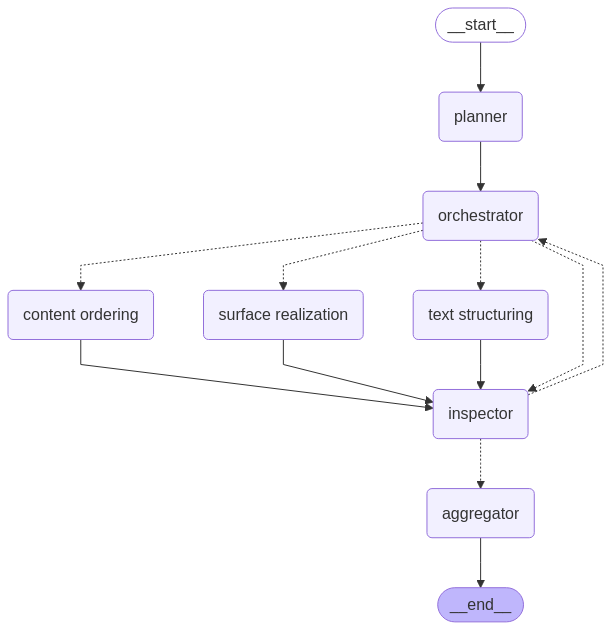

In [4]:
workers_list = [key for key, value in workers.items()]

# ——— Build your StateGraph ———
agent_workflow = StateGraph(StageExecute)

# 1) planner node
agent_workflow.add_node("planner", Planner.run_model(Planner.create_model()))

# 2) orchestrator node
agent_workflow.add_node(
    "orchestrator",
    Orchestrator.run_model(Orchestrator.create_model(), workers=workers_list)
)

# 3) worker nodes
#    here `tools` can be [] or any list of LangChain tools you have;
#    `initial_query` is whatever you're passing in as the user input.
tools = []
initial_query = StageExecute["input"]  # or whatever your entry payload is
worker_names = add_workers(workers, agent_workflow, tools, initial_query)
agent_workflow.add_node("inspector", Inspector.run_model(Inspector.create_model()))
agent_workflow.add_node("aggregator", ResponseAggregator.run_model(ResponseAggregator.create_model()))


# 4) wire up the edges
#  start → planner → orchestrator
agent_workflow.add_edge(START, "planner")
agent_workflow.add_edge("planner", "orchestrator")

#  orchestrator uses the "next" field in state to pick which worker to run
#  we map each worker name to itself, and FINISH to END
conditional_map = {name: name for name in worker_names}
conditional_map["inspector"] = "inspector"  # Add inspector explicitly

agent_workflow.add_conditional_edges(
    "orchestrator",
    lambda state: state["next"],
    conditional_map
)

#  after a worker runs, end the graph
for name in worker_names:
    agent_workflow.add_edge(name, "inspector")
    
agent_workflow.add_conditional_edges("inspector", transition_after_inspection)
agent_workflow.add_edge("aggregator", END)

#  set the entry point
agent_workflow.set_entry_point("planner")

#  compile into a runnable app
process_flow = agent_workflow.compile()

display(Image(process_flow.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
data = """<page_title> 2009 NASCAR Camping World Truck Series </page_title> 
<section_title> Schedule </section_title> 
<table> 
    <cell> August 1 <col_header> Date </col_header> </cell> 
    <cell> Toyota Tundra 200 <col_header> Event </col_header> </cell> 
    <cell> Nashville Superspeedway <col_header> Venue </col_header> </cell> 
</table>"""


In [ ]:
data = """<page_title> 2009 NASCAR Camping World Truck Series </page_title> 
<section_title> Schedule </section_title> 
<table> 
  <cell> Toyota Tundra 200 <col_header> Event </col_header> </cell> 
  <cell> August 1 <col_header> Date </col_header> </cell> 
  <cell> Nashville Superspeedway <col_header> Venue </col_header> </cell> 
</table>"""

In [ ]:
import os
import json

# === Test it out ===
data = """<page_title> Kieran Bew </page_title> <section_title> Television </section_title> <table> <cell> Hans Christian Andersen: My Life as a Fairytale <col_header> Show </col_header> </cell> <cell> Hallmark Entertainment <col_header> Notes </col_header> </cell> <cell> The Street <col_header> Year </col_header> </cell> <cell> Gary Parr <col_header> Show </col_header> </cell> <cell> Da Vinci's Demons <col_header> Show </col_header> </cell> <cell> Duke Alphonso of Calabria <col_header> Role </col_header> </cell> </table>"""

ground_truth = "Kieran Bew appeared in Da Vinci's Demons as Duke of Calabria, as Gary Parr in The Street and in Hans Christian Andersen: My Life as a Fairytale for Hallmark Entertainment."

query = f"""You are an agent designed to generate text from data for a data-to-text natural language generation. You can be provided data in the form of xml, table, meaning representations, graphs etc. 
Your task is to generate the appropriate text given the data information without omitting any field or adding extra information in essence called hallucination.
Here is the data generate text using table data:
{data}"""

initial_state = {
    "input": query,
    "plan": [],
    "result_steps": [],
    "response": "",
    "chat_history": [],
    "next": "",
    "agent_outcome": "",
    "current_step": 0,
    "team_iterations": 10,
    "recursion_limit": 60,
}

state = process_flow.invoke(initial_state, config={"recursion_limit": initial_state["recursion_limit"]})
print(state)



> Entering new AgentExecutor chain...
Action:
```
{
  "action": "Clarify",
  "action_input": "What is the purpose of content ordering?"
}
```
Clarify is not a valid tool, try one of [].Action:
```
{
  "action": "Provide Definition",
  "action_input": "Content ordering is the process of arranging data in a logical and effective sequence to support clarity and coherence in the final text."
}
```Provide Definition is not a valid tool, try one of [].Action:
```
{
  "action": "Provide Definition",
  "action_input": "Content ordering is the process of arranging data in a logical and effective sequence to support clarity and coherence in the final text."
}
```Provide Definition is not a valid tool, try one of [].Action:
```
{
  "action": "Provide Definition",
  "action_input": "Content ordering is the process of arranging data in a logical and effective sequence to support clarity and coherence in the final text."
}
```Provide Definition is not a valid tool, try one of [].

> Finished chain

In [14]:
print(state['response'])

Based on the provided data and the completed steps, I will generate the final natural language output.

The 2009 NASCAR Camping World Truck Series schedule includes a single event:

On August 1, the Toyota Tundra 200 took place at Nashville Superspeedway. This event was held at the venue of Nashville Superspeedway.

If you would like to know more about this event or any other information related to the 2009 NASCAR Camping World Truck Series schedule, please let me know and I'll be happy to assist you further.


In [7]:
state

{'input': 'You are an agent designed to generate text from data for a data-to-text natural language generation. You can be provided data in the form of xml, table, meaning representations, graphs etc. \nYour task is to generate the appropriate text given the data information without omitting any field or adding extra information in essence called hallucination.\nHere is the data:\n<page_title> 2009 NASCAR Camping World Truck Series </page_title> <section_title> Schedule </section_title> <table> <cell> August 1 <col_header> Date </col_header> </cell> <cell> Toyota Tundra 200 <col_header> Event </col_header> </cell> <cell> Nashville Superspeedway <col_header> Venue </col_header> </cell> </table>',
 'plan': [],
 'result_steps': [ResultStep(agent='planner', input='INPUT\n----- ----- ----- -----\n\nUSER: You are an agent designed to generate text from data for a data-to-text natural language generation. You can be provided data in the form of xml, table, meaning representations, graphs etc.

In [8]:
import os
import json

dir_path = "results"
file_path = os.path.join(dir_path, "result.json")

os.makedirs(dir_path, exist_ok=True)

if os.path.isdir(file_path):
    raise IsADirectoryError(f"Cannot write to '{file_path}' because it is a directory.")

# Prepare serializable version of state
def make_serializable(obj):
    if isinstance(obj, list):
        return [make_serializable(item) for item in obj]
    elif hasattr(obj, "model_dump"):  # For Pydantic BaseModel subclasses like ResultStep
        return obj.model_dump()
    elif isinstance(obj, dict):
        return {k: make_serializable(v) for k, v in obj.items()}
    else:
        return obj

serializable_state = make_serializable(dict(state))

with open(file_path, "w") as f:
    json.dump(serializable_state, f, indent=4)


In [9]:
# from datasets import load_dataset

# rotowire = load_dataset("mrm8488/rotowire-sbnation")
# turku_hockey = datasets.load_dataset('GEM/turku_hockey_data2text')
# totto = datasets.load_dataset('GEM/totto')
# basketball = datasets.load_dataset('GEM/sportsett_basketball')
# webnlg = datasets.load_dataset('GEM/web_nlg', 'en')
# weather = datasets.load_dataset('GEM/conversational_weather')
# dart = datasets.load_dataset('GEM/dart')
# mlb = datasets.load_dataset('GEM/mlb_data_to_text')

In [10]:
# from langgraph.graph import START, END, StateGraph
# from utils import StageExecute, Agent, AgentExecuteInput
# from IPython.display import Image, SVG, display
# from typing import List, Literal, Optional, Text, Union, Dict, Any

# class Planner:
#     def create_model(self, task):
#         # Logic to generate plans
#         pass
#     @classmethod
#     def run_model(cls,):

#         pass

# class Orchestrator:
#     def create_model(self, task):
#         # Logic to generate plans
#         pass
#     @classmethod
#     def run_model(cls,):

#         pass

# class Worker:
#     def create_model(self, task):
#         # Logic to generate plans
#         pass
#     @classmethod
#     def run_model(cls,):

#         pass

# class Inspector:
#     def create_model(self, task):
#         # Logic to generate plans
#         pass
#     @classmethod
#     def run_model(cls,):

#         pass

# class ResponseAggregator:
#     def create_model(self, task):
#         # Logic to generate plans
#         pass
#     @classmethod
#     def run_model(cls,):

#         pass
    
# def transition_after_inspection(state: StageExecute) -> Literal["orchestrator", "aggregator"]:
#     """Decides the next stage after inspection based on task correctness."""
#     if "aggregator" in state and state["aggregator"]:
#         return "aggregator"
#     else:
#         return "orchestrator"

In [11]:
# workers = ["worker1", "worker2"]  # Example workers
# conditional_map = {worker: "inspector" for worker in workers}

# agent_workflow = StateGraph(StageExecute)
# agent_workflow.add_node("planner", Planner.run_model)
# agent_workflow.add_node("orchestrator", Orchestrator.run_model)
# agent_workflow.add_node("worker", Worker.run_model)
# agent_workflow.add_node("inspector", Inspector.run_model)
# agent_workflow.add_node("aggregator", ResponseAggregator.run_model)

# agent_workflow.add_edge(START, "planner")
# agent_workflow.add_edge("planner", "orchestrator")
# agent_workflow.add_edge("orchestrator", "worker")
# agent_workflow.add_edge("worker", "inspector")
# agent_workflow.add_conditional_edges("inspector", transition_after_inspection)
# agent_workflow.add_edge("aggregator", END)

# process_flow = agent_workflow.compile()

# display(Image(process_flow.get_graph(xray=True).draw_mermaid_png()))
# # display(SVG(process_flow.get_graph(xray=True).draw_mermaid_png()))

In [12]:
# # workers = ["worker1", "worker2"]  # Example workers
# conditional_map = {worker: "inspector" for worker in workers.keys()}

# def add_workers(tools= , query= , task_name):
# for task_name, task_description in workers.items():
    

# agent_workflow = StateGraph(StageExecute)
# agent_workflow.add_node("planner", Planner.run_model(Planner.create_model()))
# agent_workflow.add_node("orchestrator", Orchestrator.run_model(Orchestrator.create_model(), workers=workers_list))
# agent_workflow.add_node("worker", Worker.run_model(Worker.create_model(tools=workers_list, query=StageExecute["input"]), task_name=))
# # agent_workflow.add_node("inspector", Inspector.run_model)
# # agent_workflow.add_node("aggregator", ResponseAggregator.run_model)

# agent_workflow.add_edge(START, "planner")
# agent_workflow.add_edge("planner", "orchestrator")
# agent_workflow.add_edge("orchestrator", "worker")
# agent_workflow.add_edge("worker", END)
# # agent_workflow.add_edge("worker", "inspector")
# # # agent_workflow.add_edge("inspector", "orchestrator")
# # agent_workflow.add_conditional_edges("inspector", transition_after_inspection)
# # agent_workflow.add_edge("aggregator", END)

# process_flow = agent_workflow.compile()

# # display(Image(process_flow.get_graph(xray=True).draw_mermaid_png()))

In [13]:
# workers = {
#     "content selection": (
#         "The Content Selection agent is responsible for analyzing the raw input data, identifying the key "
#         "elements and relevant features that will form the backbone of the final text output. This agent "
#         "meticulously scans through tables, XML, or any structured data provided, and it distinguishes between "
#         "important information and peripheral details. Its tasks include filtering out noise, determining "
#         "salient content based on context, and ensuring that no essential data points are missed. The output "
#         "from this agent provides a curated list of information that will serve as the foundation for generating "
#         "a coherent and accurate text narrative."
#     ),
#     "text structuring": (
#         "The Text Structuring agent is tasked with taking the curated content from the Content Selection agent "
#         "and organizing it into a fluid and engaging narrative. This agent focuses on the arrangement, flow, "
#         "and logical segmentation of the text to ensure that the final output is not only accurate but also easily "
#         "comprehensible and well-structured. It works by mapping out the overall framework of the narrative, "
#         "allocating content into sections, and applying linguistic transformations that enhance readability. "
#         "Its work ensures that the text is not a mere aggregation of data points, but a well-crafted piece "
#         "that reflects both the detailed insights of the data and the clarity required for a high-quality narrative."
#     ),
#     "surface realization": (
#         "The Surface Realization agent is responsible for generating fluent and grammatically correct natural language "
#         "text from the structured and organized content provided by the previous stages. It combines the selected content "
#         "and structured layout to form complete sentences, using appropriate lexical choices, syntactic constructions, "
#         "and discourse markers. This agent ensures that the final text adheres to linguistic norms, maintains coherence, "
#         "and reads naturally as if written by a human."
#     )
# }